# Signal Processing

The notebook goes into more detail on the processing of the 12 ECG data per patient. First, the signal itself is considered and then the ECG signal processing methods integrated in the 'wfdb' module are explored. Various approaches are then used to normalize the data and reduce noise in order to make the signals as comparable as possible.

In [2]:
import pickle
from matplotlib import pyplot as plt
import wfdb.processing
import scipy.signal
import numpy as np

In [3]:
path = "C:/Studium/dsa/data"
#path = "C:/Users/Nils/Documents/HS-Mannheim/0000_MASTER/DSA/EKG_Prog/data"

## Load Data

In [4]:

# read pickle files and check len and print first record and first record keys



categories_dict = {
'SB':    [426177001],
'AFIB':  [164889003, 164890007],
'GSVT':  [426761007, 713422000, 233896004, 233897008, 713422000],
'SR':    [426783006, 427393009]
}


data = {}
for cat_name in categories_dict.keys():
    print(f"Reading {cat_name}")
    with open(f'{path}/{cat_name}.pkl', 'rb') as f:
        records = pickle.load(f)
        data[cat_name] = records
        print(f"Length of {cat_name}: {len(records)}")

Reading SB
Length of SB: 16559
Reading AFIB
Length of AFIB: 9839
Reading GSVT
Length of GSVT: 948
Reading SR
Length of SR: 9720


For a better understanding of the structure and dimensions of the individual data sets, there are printed.

In [5]:
# print keys of first record
print(f"Keys of first record of SB: {data['SB'][0].__dict__.keys()}")
print(data['SB'][0].__dict__)
print(data['SB'][0].__dict__['p_signal'].shape)

Keys of first record of SB: dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])
{'record_name': 'JS00002', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['Age: 59', 'Sex: Female', 'Dx: 426177001,164934002', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknown'], 'sig_name': ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.01 ,  0.01 ,  0.02 , ...,  0.054,  0.049,  0.   ],
       [-0.024, -0.02 ,  0.005, ...,  0.034,  0.034, -0.015],
       [-0.02 , -0.02 ,  0.   , ...,  0.034,  0.034, -0.01 ],
       ...,
       [ 0.015,  0.01 , -0.005, ..., -0.015, -0.02 ,  0.005],
    

In [6]:
# count how many different signals are available
counter_p = 0
counter_e_p = 0
counter_d = 0
counter_e_d = 0
for record in data['SR']:
    if record.p_signal is not None:
        counter_p += 1
    if record.e_p_signal is not None:
        counter_e_p += 1
    if record.d_signal is not None:
        counter_d += 1

print(f"Number of records with p_signal: {counter_p}")
print(f"Number of records with e_p_signal: {counter_e_p}")
print(f"Number of records with d_signal: {counter_d}")
print(f"Number of records with e_d_signal: {counter_e_d}")

Number of records with p_signal: 9720
Number of records with e_p_signal: 0
Number of records with d_signal: 0
Number of records with e_d_signal: 0


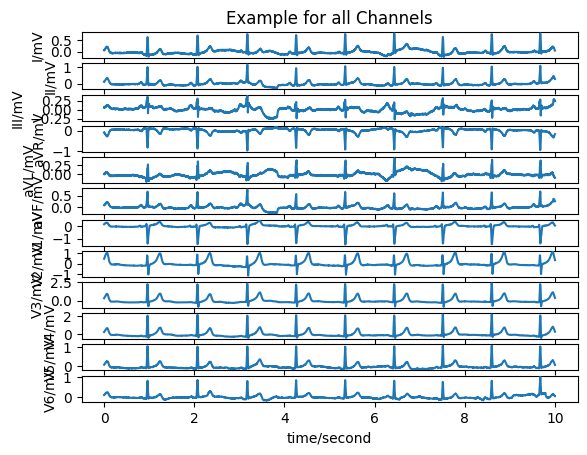

In [7]:
#Plot a complete Record
wfdb.plot_wfdb(data['SB'][24],title="Example for all Channels")

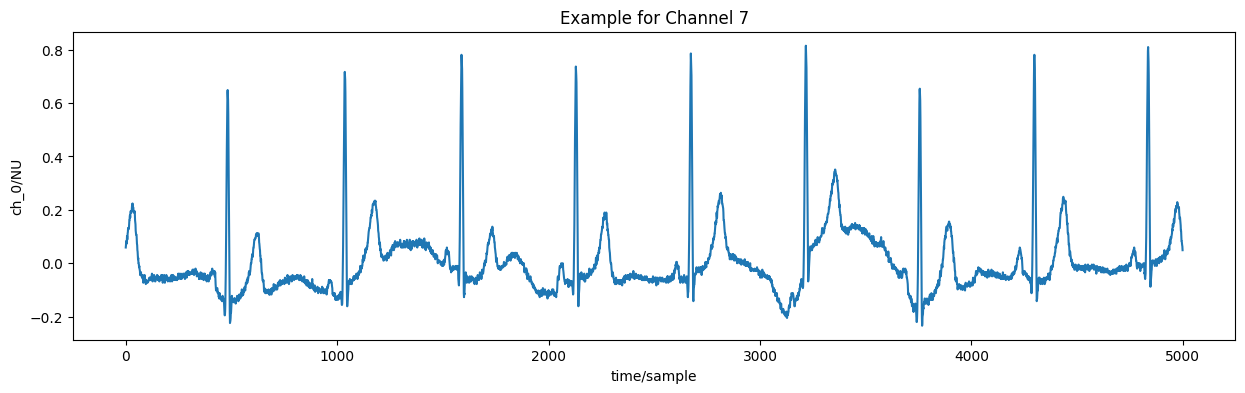

In [8]:
#Plot specific Channel of Record
fig = wfdb.plot_items(data['SB'][24].p_signal[:,0],title="Example for Channel 7",figsize=(15,4),return_fig=True)

In [9]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(data['SB'][24].p_signal[:,6],radius=3)
record = data['SB'][24].p_signal[:,6]
wholeRecord = data['SB'][24]
peak_points_y = [record[i] for i in hard] 

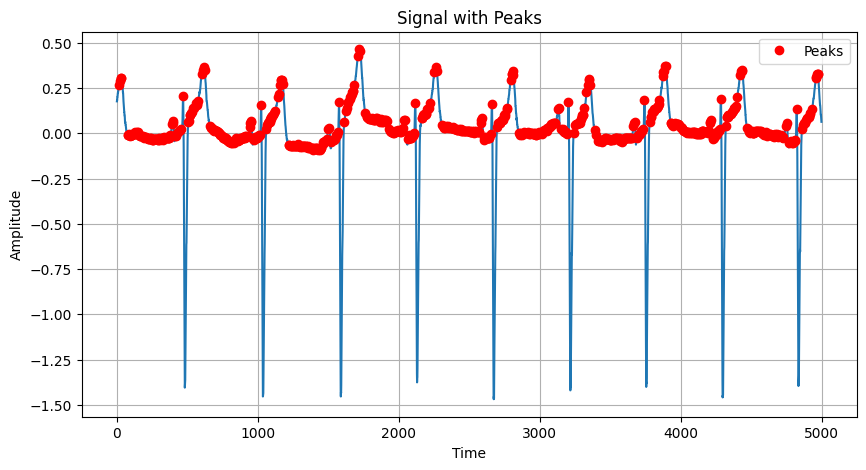

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(wholeRecord.p_signal[:,6],wholeRecord.fs,0,5000)
print(indicies)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 484 1038 1590 2131 2675 3219 3758 4300 4838]


In [12]:
# Normalization through upper and lower bounds (“Y-axis normalization”)
print("For normalization:   ", wholeRecord.p_signal[:,0])
wholeRecord.p_signal[:,0] = wfdb.processing.normalize_bound(wholeRecord.p_signal[:,0],0,1)
print("After normalization: ",wholeRecord.p_signal[:,0])



For normalization:    [0.059 0.068 0.083 ... 0.068 0.063 0.049]
After normalization:  [0.27931363 0.28789323 0.30219256 ... 0.28789323 0.28312679 0.26978074]


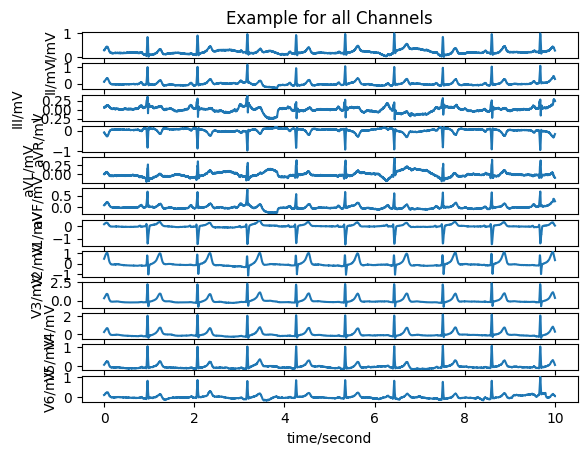

In [13]:
wfdb.plot_wfdb(wholeRecord,title="Example for all Channels")


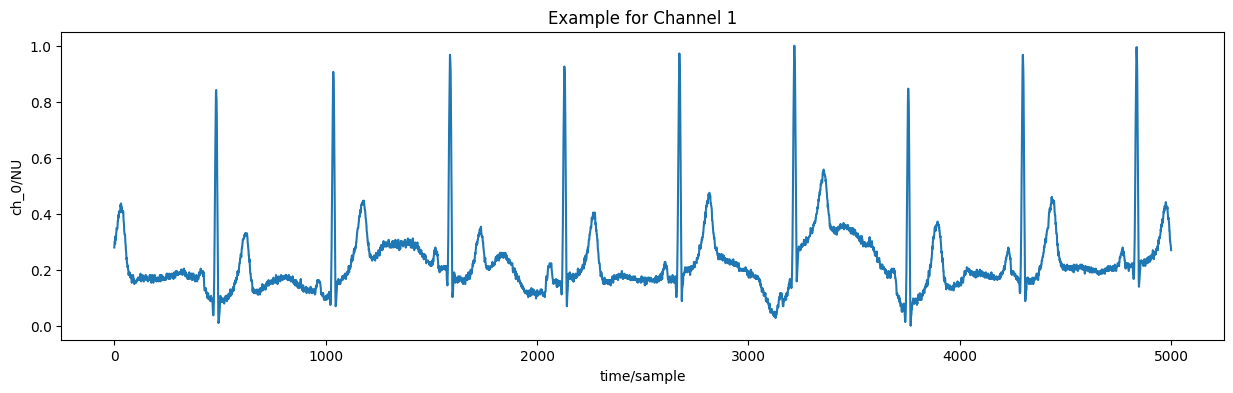

In [14]:
wfdb.plot_items(data['SB'][24].p_signal[:,0],title="Example for Channel 1",figsize=(15,4))

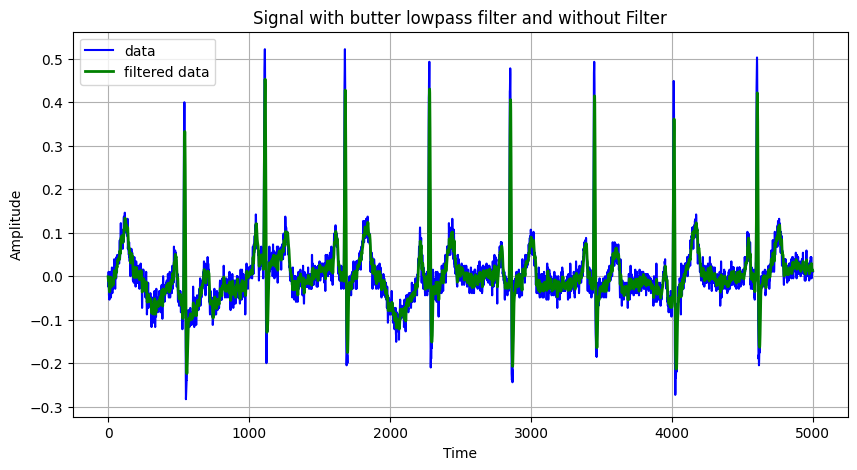

In [15]:
test_data = data['SB'][0].p_signal[:,0]


from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.

order = 1
fs = 500.0
cutoff = 25#25

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Apply filter to the signal
butter_filtered_sig = butter_lowpass_filter(test_data, cutoff, fs, order)

# Plot the signal
plt.figure(figsize=(10, 5))
plt.plot(test_data, 'b-', label='data')
plt.plot(butter_filtered_sig, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with butter lowpass filter and without Filter')
plt.legend()
plt.grid(True)
plt.show()

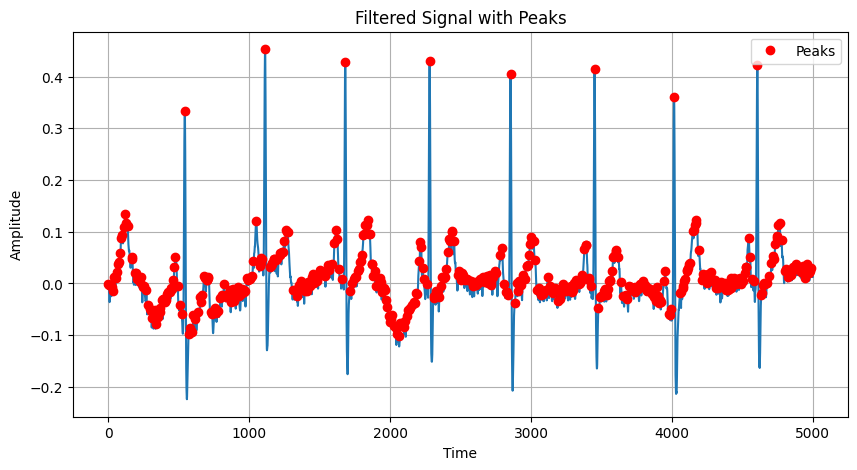

In [16]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(butter_filtered_sig,radius=3)
record = butter_filtered_sig
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 544 1114 1683 2281 2855 3452 4016 4606]


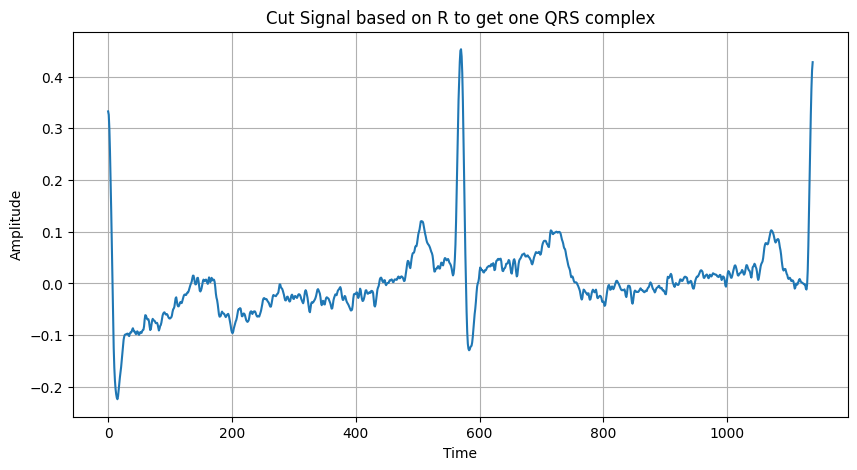

In [17]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(butter_filtered_sig,500,0,5000)
print(indicies)

# detected = [ 530 1076 1631 2174 2725 3281 3828 4378 4938]
cut_signal = butter_filtered_sig[indicies[0]:indicies[2]]

# plot the cut signal
plt.figure(figsize=(10, 5))
plt.plot(cut_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal based on R to get one QRS complex')
plt.grid(True)
plt.show()

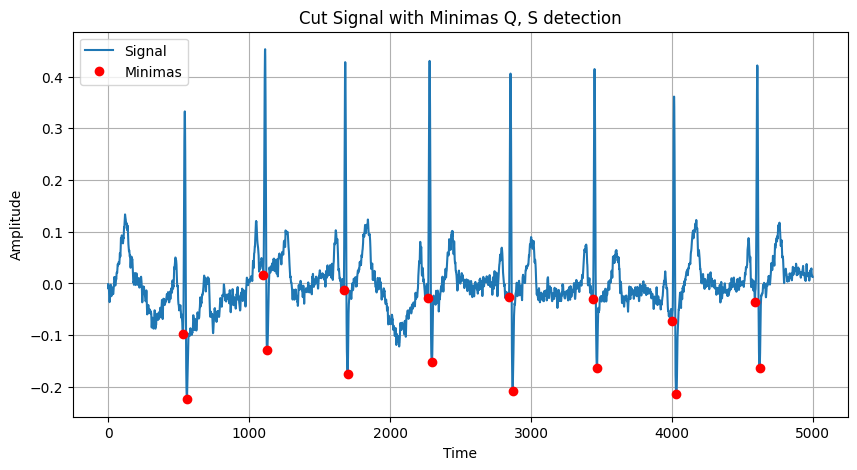

[-0.03577630855309041, -0.16337948001854852]


In [18]:
plt.figure(figsize=(10, 5))
plt.plot(butter_filtered_sig)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal with Minimas Q, S detection')
plt.grid(True)

for peak in indicies:
    start_idx = 20
    end_idx = 25
    signal_section = butter_filtered_sig[peak-start_idx:peak+end_idx]
    minimas = scipy.signal.argrelextrema(signal_section, comparator=np.less, order=5)
    
    # map the minimas to the original signal
    minimas = minimas[0] + peak - start_idx
    minimas_y = [butter_filtered_sig[i] for i in minimas]
    # if minimas more than 2 take those with biggest difference in y
    if len(minimas) > 2:
        minimas_y = [butter_filtered_sig[i] for i in minimas]
        minimas_y = sorted(minimas_y)
        minimas_y = minimas_y[:2]
        minimas = [minimas[i] for i in range(0,2)]

    # plot the minimas
    plt.plot(minimas, minimas_y, 'ro')

plt.legend(['Signal', 'Minimas'])
plt.show()

#print y values of minimas
print(minimas_y)

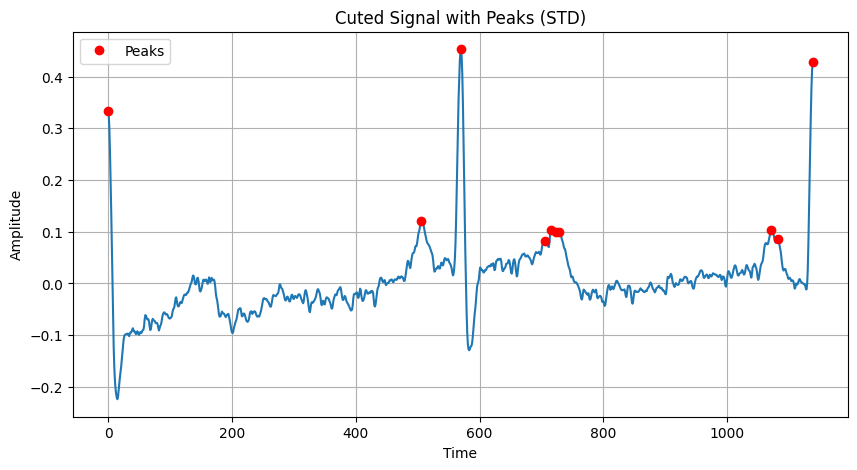

In [19]:
# find peaks in the cut signal
hard = wfdb.processing.find_local_peaks(cut_signal,radius=3)
#peak_points_y = [cut_signal[i] for i in hard]

tolerance = 1
# get standard deviation of the hard peaks
std = cut_signal[hard].std() * tolerance
# filter peaks with std
hard = [i for i in hard if cut_signal[i] > std]
# get the y values of the peaks
peak_points_y = [cut_signal[i] for i in hard]

plt.figure(figsize=(10, 5))
plt.plot(cut_signal)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cuted Signal with Peaks (STD)')
plt.legend()
plt.grid(True)
plt.show()

(5000, 2)


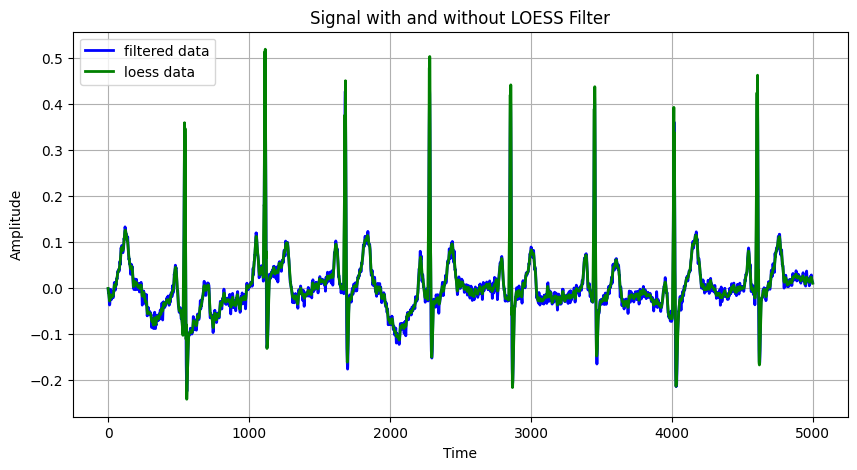

In [20]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

org_signal = butter_filtered_sig 
#org_signal = test_data
x = org_signal
y = np.arange(len(org_signal))

# Apply lowess function
frac = 0.003#0.01
lowess_filtered_sig = lowess(x, y, is_sorted=True, frac=frac, it=1)
print(lowess_filtered_sig.shape)
# Plot the signal
plt.figure(figsize=(10, 5))
plt.plot(org_signal, 'b-', linewidth=2, label='filtered data')
plt.plot(lowess_filtered_sig[:, 0], lowess_filtered_sig[:, 1], 'g-', linewidth=2, label='loess data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without LOESS Filter')
plt.legend()
plt.grid(True)
plt.show()

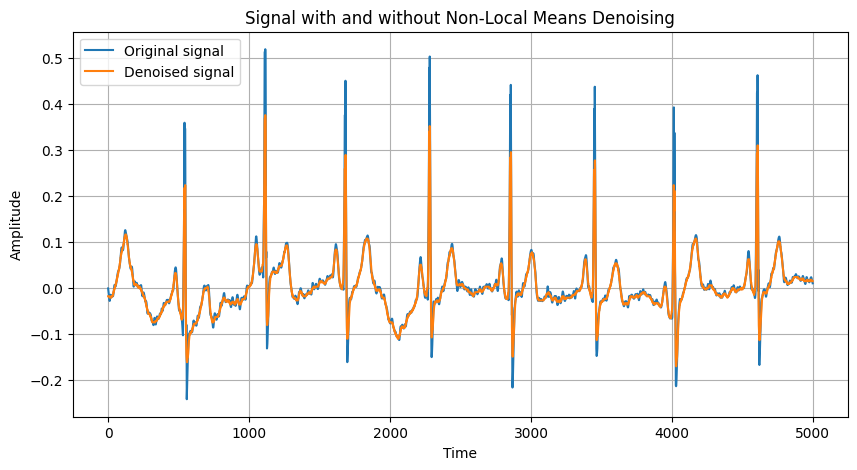

In [21]:
import cv2 as cv


org_signal = lowess_filtered_sig[:, 1]
#org_signal = test_data

# Reshape the signal to a 2D array for OpenCV (camera image processing library)
org_signal_2d = np.reshape(org_signal, (-1, 1))

# Scale the signal to the range [0, 255] (normal pixel range for images)
org_signal_2d_scaled = np.uint8((org_signal_2d - np.min(org_signal_2d)) / (np.max(org_signal_2d) - np.min(org_signal_2d)) * 255)

# Apply Non-Local Means denoising

filter_strength = 50
template_window_size = 7
search_window_size = 21

nlm_filtered_sig_2d = cv.fastNlMeansDenoising(org_signal_2d_scaled, None, filter_strength, template_window_size, search_window_size)

# Rescale the denoised signal back to the original range
nlm_filtered_sig = np.reshape(nlm_filtered_sig_2d, -1) * (np.max(org_signal) - np.min(org_signal)) / 255 + np.min(org_signal)


# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(org_signal, label='Original signal')
plt.plot(nlm_filtered_sig, label='Denoised signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Non-Local Means Denoising')
plt.legend()
plt.grid(True)
plt.show()

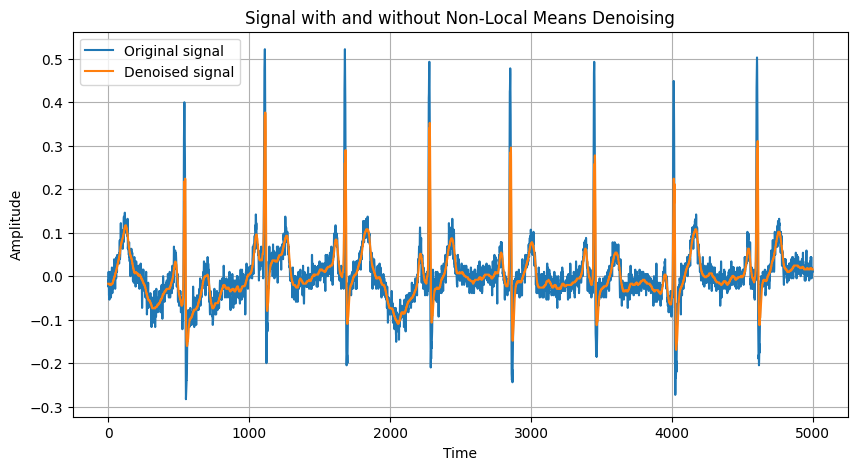

In [22]:
# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(test_data, label='Original signal')
plt.plot(nlm_filtered_sig, label='Denoised signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Non-Local Means Denoising')
plt.legend()
plt.grid(True)
plt.show()

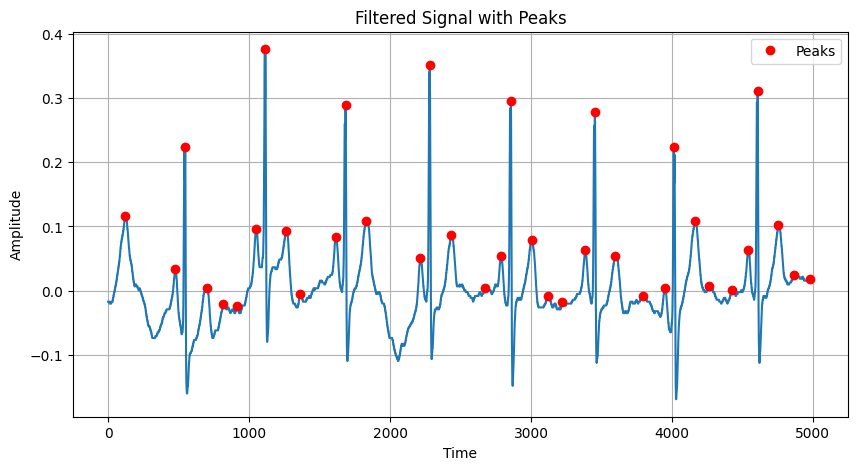

In [23]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(nlm_filtered_sig,radius=50)
record = nlm_filtered_sig
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

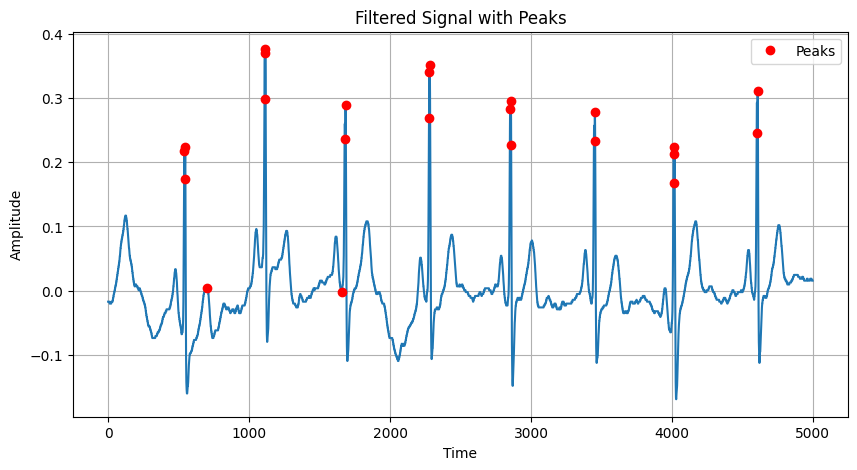

In [24]:
#Find peaks in Channel 6 of Record 25
hard, soft = wfdb.processing.find_peaks(nlm_filtered_sig)
record = nlm_filtered_sig
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
filter_params = {
    'names': ['butterlowpass', 'lowess', 'non_local_means'],
    # params for butterworth filter
    'order':1,
    'fs':500.0,
    'cutoff':25,
    # params for lowess filter
    'filter_strength':50,
    'template_window_size':7,
    'search_window_size':21,
    # params for nlm filter
    'frac':0.003,
    'it':1
}


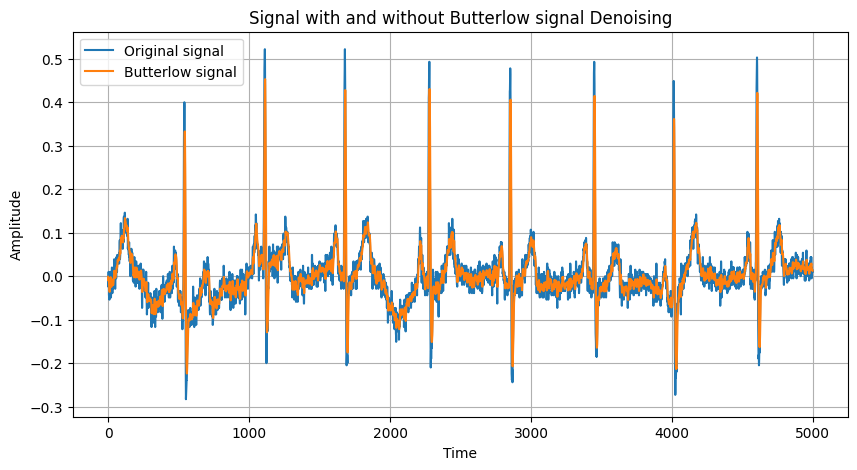

In [27]:
butter_filtered_sig = data_helper.butterlowpass_filter(data['SB'][0], filter_params['cutoff'], filter_params['fs'], filter_params['order'])
# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(data['SB'][0].p_signal[:,0], label='Original signal')
plt.plot(butter_filtered_sig.p_signal[:,0], label='Butterlow signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Butterlow signal Denoising')
plt.legend()
plt.grid(True)
plt.show()

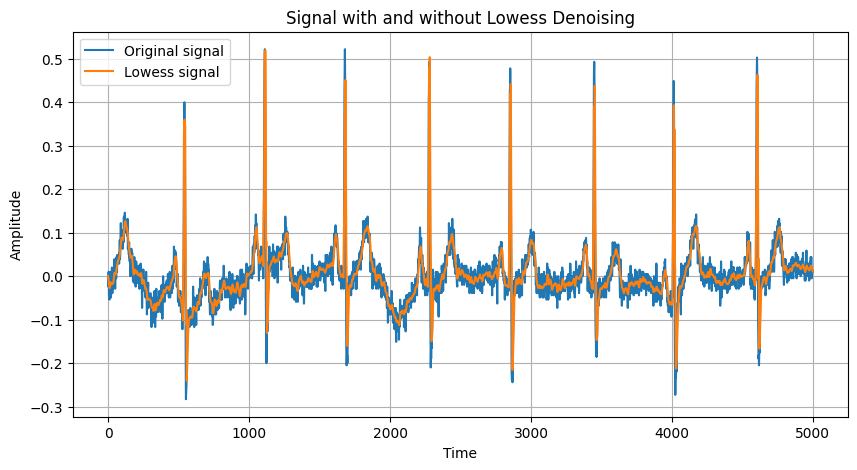

In [28]:
lowess_filtered_sig = data_helper.lowess_filter(butter_filtered_sig, filter_params['frac'], filter_params['it'])
# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(data['SB'][0].p_signal[:,0], label='Original signal')
plt.plot(lowess_filtered_sig.p_signal[:,0], label='Lowess signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Lowess Denoising')
plt.legend()
plt.grid(True)
plt.show()

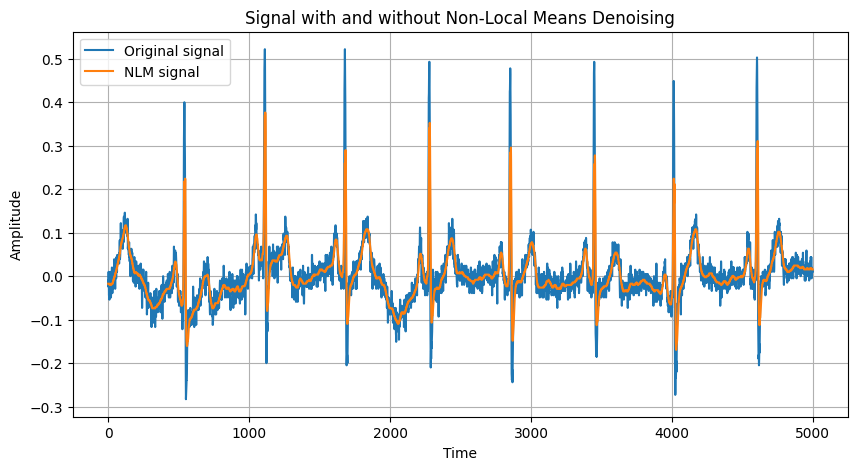

In [29]:
nlm_filtered_sig = data_helper.non_local_means_filter(lowess_filtered_sig, filter_params['filter_strength'], filter_params['template_window_size'], filter_params['search_window_size'])
# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(data['SB'][0].p_signal[:,0], label='Original signal')
plt.plot(nlm_filtered_sig.p_signal[:,0], label='NLM signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Non-Local Means Denoising')
plt.legend()
plt.grid(True)
plt.show()

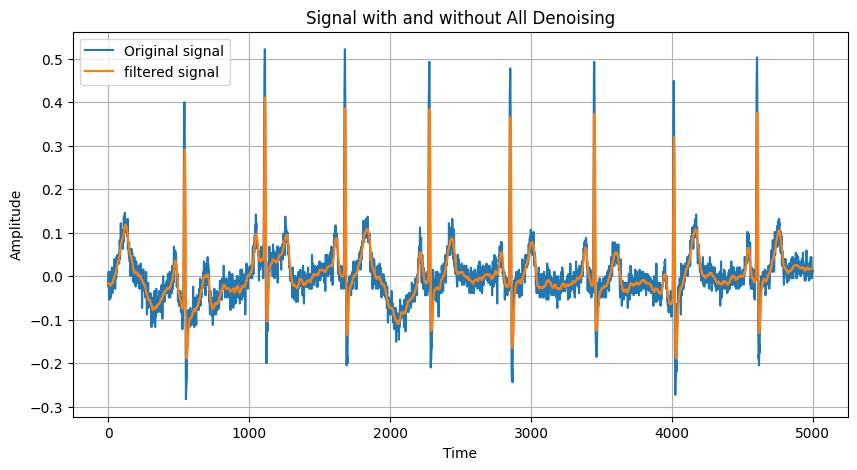

In [30]:
all_filtered_signals = data_helper.filter_data(data['SB'][0], filter_params)
# Plot the original and denoised signal
plt.figure(figsize=(10, 5))
plt.plot(data['SB'][0].p_signal[:,0], label='Original signal')
plt.plot(all_filtered_signals.p_signal[:,0], label='filtered signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without All Denoising')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
%%time
all_filtered_signals = data_helper.filter_data(data['SB'][:10], filter_params)

CPU times: total: 41.5 s
Wall time: 55.3 s
